# **Library Imports**

In [1]:
import pandas as pd
import pickle 
import matplotlib.pyplot as plt
import re 
import numpy as np
from wordcloud import WordCloud

# Natural Language Processing
import nltk 
nltk.download("all")
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize

# Feature extraction
import gensim
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Machine Learning Classifiers 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Deep learning Classifers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot

# Splitting + Metrics + Hypertuning + Visualisation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE 

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

# **Loading and Formatting Data**

In [2]:
# Dataset: https://zenodo.org/record/4282522#.YKKbyqhKhyw
# Focusing exclusively on supervised learning 
PATH = "/content/drive/MyDrive/Comp-Modelling/COVID Fake News Data.csv"
df = pd.read_csv(PATH) 

# There is a clear inbalance between the number of fake and real article headlines
df['outcome'].value_counts() 

# Balancing so real and fake are at ratio 50:50
# i.e. normalising the distribution of the data 
real = df.loc[df['outcome'] == 0]
fake = df.loc[df['outcome'] == 1]

df = pd.concat([real[:450], fake[:450]], ignore_index=True) 
# Our new corpus contains 900 COVID-19 articles, 450 real and 450 fake

df.head()
df_deep = df.copy(deep=True) # Make a copy of the original data for deep-learning

# **Data Preprocessing**

In [3]:
# Standard processesing pipeline: 
# 1. Remove punctuation, make lower-case, tokenize
# 2. Remove stop-words
# 3. Apply stemming 

def process(text):
  text = re.sub('[^a-zA-Z\s]+', '', text).lower() # Remove punctuation and make lower-case
  tokenize_text = word_tokenize(text) # Convert sentance to list of tokens

  # Remove the stop-words in article title 
  filtered_text = [word for word in tokenize_text if not word in stop]

  # Apply stemming 
  token_sentance = [] 
  for word in filtered_text:
    token_sentance.append(stemmer.stem(word))
  token_sentance = " ".join(token_sentance) 
  return token_sentance

stemmer = PorterStemmer() # We select the porter stemmer algorithm
stop = stopwords.words("english")

# Apply pre-processing filter 
df['headlines'] = df['headlines'].apply(process) 

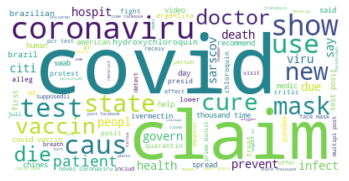

In [4]:
# Fake news word cloud 
fake_news = df.loc[df['outcome']==0]['headlines'].sum() 
cloud = WordCloud(max_words=100, background_color='white')
cloud.generate(fake_news) 
plt.imshow(cloud, interpolation="bilinear") 
plt.axis("off") 
plt.show() 

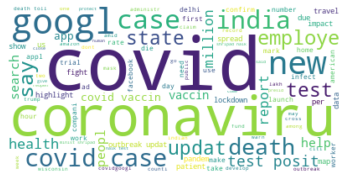

In [5]:
# Real news word cloud 
real_news = df.loc[df['outcome']==1]['headlines'].sum()
cloud = WordCloud(max_words=100, background_color='white')
cloud.generate(real_news) 
plt.imshow(cloud, interpolation="bilinear") 
plt.axis("off") 
plt.show() 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


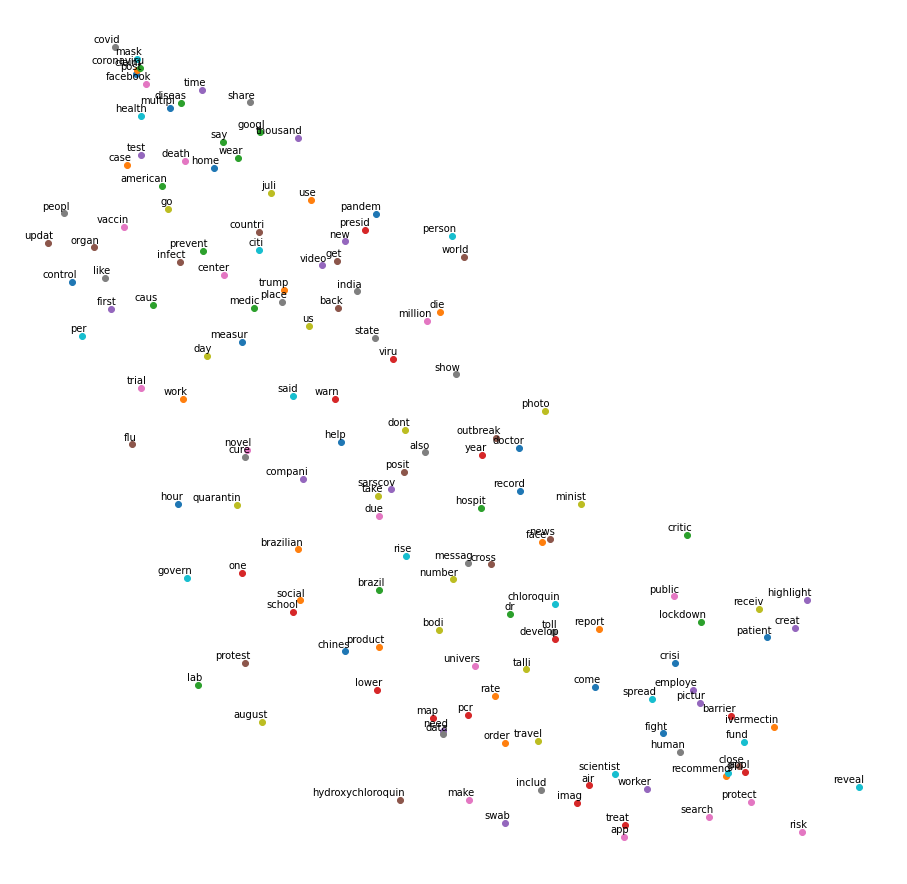

In [6]:
# Using word2vect to visualise relationships between words
words = [x.split() for x in df['headlines'].tolist()]
visualisation_model = gensim.models.Word2Vec(sentences=words, size=100, window=20, min_count=10, workers=4)

# t-SNE visualisation of word2vec vectors
# Taken directly from: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.axis("off") # added
    plt.show()

# Allows us to visualise similarity between objects
tsne_plot(visualisation_model)

# **Feature Extraction**

In [7]:
# Bag of words, using unigrams, bigrams and trigrams
# 2 Bag of words models, a standard TF, and a TF-IDF count
tf = CountVectorizer(ngram_range=(1,3), max_features=5000)
tfidf = TfidfVectorizer(ngram_range=(1,3), max_features=5000)

# Convert article data to vector features
tf_data = tf.fit_transform(df['headlines']).toarray()
tfidf_data = tfidf.fit_transform(df['headlines']).toarray() 

In [8]:
# Creating a test/train split for both the TF feature-data and TF-IDF feature-data
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tf_data, df['outcome'], test_size=0.2, random_state=0)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(tfidf_data, df['outcome'], test_size=0.2, random_state=0)

# **Machine Learning Classifiers**
Naive Bayes, Random Forest, Logistic Regression, Support Vector Machine

**Naive Bayes**

In [9]:
# TF
mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train_tf) 
model_predictions = mnb.predict(X_test_tf) 
print(f"Accuracy: {accuracy_score(y_test_tf, model_predictions)}")
print(classification_report(y_test_tf, model_predictions)) 

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        83
           1       0.84      0.90      0.87        97

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180



In [10]:
# TF-IDF 
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train_tfidf) 
model_predictions = mnb.predict(X_test_tfidf) 
print(f"Accuracy: {accuracy_score(y_test_tfidf, model_predictions)}")
print(classification_report(y_test_tfidf, model_predictions))

Accuracy: 0.85
              precision    recall  f1-score   support

           0       0.83      0.84      0.84        83
           1       0.86      0.86      0.86        97

    accuracy                           0.85       180
   macro avg       0.85      0.85      0.85       180
weighted avg       0.85      0.85      0.85       180



**Random Forest**

In [11]:
# TF
rfc = RandomForestClassifier(random_state=8) 
rfc.fit(X_train_tf, y_train_tf) 
model_predictions = rfc.predict(X_test_tf) 
print(f"Accuracy: {accuracy_score(y_test_tf, model_predictions)}")
print(classification_report(y_test_tf, model_predictions))  

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.79      0.87      0.83        83
           1       0.88      0.80      0.84        97

    accuracy                           0.83       180
   macro avg       0.83      0.84      0.83       180
weighted avg       0.84      0.83      0.83       180



In [12]:
# TF-IDF
rfc = RandomForestClassifier(random_state=8) 
rfc.fit(X_train_tfidf, y_train_tfidf)
model_predictions = rfc.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test_tfidf, model_predictions)}")
print(classification_report(y_test_tfidf, model_predictions)) 

Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        83
           1       0.89      0.81      0.85        97

    accuracy                           0.84       180
   macro avg       0.84      0.85      0.84       180
weighted avg       0.85      0.84      0.84       180



**Logistic Regression**

In [13]:
# TF
lr = LogisticRegression() 
lr.fit(X_train_tf, y_train_tf)
model_predictions = lr.predict(X_test_tf)
print(f"Accuracy: {accuracy_score(y_test_tf, model_predictions)}")
print(classification_report(y_test_tf, model_predictions)) 

Accuracy: 0.8444444444444444
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        83
           1       0.91      0.79      0.85        97

    accuracy                           0.84       180
   macro avg       0.85      0.85      0.84       180
weighted avg       0.85      0.84      0.84       180



In [14]:
# TF-IDF
lr = LogisticRegression() 
lr.fit(X_train_tfidf, y_train_tfidf)
model_predictions = lr.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test_tfidf, model_predictions)}")
print(classification_report(y_test_tfidf, model_predictions)) 

Accuracy: 0.8388888888888889
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        83
           1       0.93      0.76      0.84        97

    accuracy                           0.84       180
   macro avg       0.85      0.85      0.84       180
weighted avg       0.85      0.84      0.84       180



**Support Vector Machine**

In [15]:
# TF
svc = SVC(kernel='linear') 
svc.fit(X_train_tf, y_train_tf) 
model_predictions = svc.predict(X_test_tf) 
print(f"Accuracy: {accuracy_score(y_test_tf, model_predictions)}")
print(classification_report(y_test_tf, model_predictions)) 

Accuracy: 0.8388888888888889
              precision    recall  f1-score   support

           0       0.78      0.90      0.84        83
           1       0.90      0.78      0.84        97

    accuracy                           0.84       180
   macro avg       0.84      0.84      0.84       180
weighted avg       0.85      0.84      0.84       180



In [16]:
# TF-IDF
svc = SVC(kernel='linear') 
svc.fit(X_train_tfidf, y_train_tfidf) 
model_predictions = svc.predict(X_test_tfidf) 
print(f"Accuracy: {accuracy_score(y_test_tfidf, model_predictions)}")
print(classification_report(y_test_tfidf, model_predictions)) 

Accuracy: 0.8555555555555555
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        83
           1       0.92      0.80      0.86        97

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



# **Hypertuning Parameters**
The best model is the SVM, so we hypertune its parameters below

In [17]:
# The best model obtained was the SVM with TF-IDF features 

# Creating hyper-parameter search space
# Using a linear kernel so we don't have to optimize the gamma parameter
param_grid = {'C' : [0.1, 1, 10, 100, 1000],
              'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel' : ['linear']
             }


grid_svm = GridSearchCV(estimator=svc, param_grid=param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
grid_svm.fit(X_train_tfidf, y_train_tfidf)
print(grid_svm.best_estimator_)
print(grid_svm.best_score_)
print(grid_svm.best_params_)

grid_predictions = grid_svm.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test_tfidf, grid_predictions)}")

# The best parameters found for our model are: {'C': 10, 'gamma': 1, 'kernel': 'linear'}
# These achieve a train accuracy of 0.8875 and test accuracy of 0.856 -> unfortunately no improvement
# Save this model so we can load it in later
pickle.dump(grid_svm, file=open("/content/drive/MyDrive/Comp-Modelling/best_SVM_model.sav", "wb"))

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  3.2min finished


SVC(C=10, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.8875
{'C': 10, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.8555555555555555


Accuracy: 0.8555555555555555
              precision    recall  f1-score   support

           0       0.80      0.92      0.85        83
           1       0.92      0.80      0.86        97

    accuracy                           0.86       180
   macro avg       0.86      0.86      0.86       180
weighted avg       0.86      0.86      0.86       180



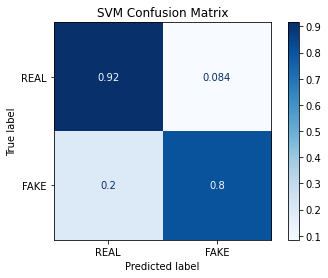

In [18]:
# Load the model in and test it 
grid_svm = pickle.load(open("/content/drive/MyDrive/Comp-Modelling/best_SVM_model.sav", "rb"))
model_predictions = grid_svm.predict(X_test_tfidf)
print(f"Accuracy: {accuracy_score(y_test_tfidf, model_predictions)}")
print(classification_report(y_test_tfidf, model_predictions)) 

# Confusion matrix based off:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
class_names = ['REAL', 'FAKE']
classifier = grid_svm
disp = plot_confusion_matrix(classifier, X_test_tfidf, y_test_tfidf, display_labels=class_names, cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("SVM Confusion Matrix")
# Shows how the test articles were classified 
plt.show() 

# **Most "Real" and "Fake" words**
Based off: https://stackoverflow.com/questions/26976362/

**Most Fake:**

In [19]:
feature_names = tfidf.get_feature_names()
classifier = svc
sorted(zip(classifier.coef_[0], feature_names))[:10]

[(-1.7670224727449084, 'claim'),
 (-1.5405755062667756, 'govern'),
 (-1.3852935850858477, 'brazil'),
 (-1.3413806892204314, 'prevent'),
 (-1.2032703858838363, 'brazilian'),
 (-1.1602668406030507, 'new coronaviru'),
 (-1.1346182691964182, 'doctor'),
 (-1.1309627566918494, 'solut'),
 (-1.0943186581715358, 'video'),
 (-1.0918795336798268, 'post')]

**Most Real**

In [20]:
sorted(zip(classifier.coef_[0], feature_names),reverse=True)[:10]

[(3.32820192416484, 'googl'),
 (1.7386320481121722, 'case'),
 (1.5118467239958067, 'say'),
 (1.468129179710436, 'india'),
 (1.4469492281383372, 'trump'),
 (1.206801304279721, 'like'),
 (1.1603457219125566, 'coronaviru'),
 (1.1236207142063352, 'app'),
 (1.0065358569045662, 'covid'),
 (0.9998505280475036, 'rate')]

# **Standard Deep Learning Classifiers**
One-hot vector features \\
LSTM = Long Term Short Memory \\
Standard LSTM, Bidirectional LSTM

In [21]:
X = df['headlines']
y = df['outcome'].values
vocab_size = 5000 

# Convert sentances to one hot vectors
one_hot_labels = [one_hot(words, vocab_size)for words in X]

# Add padding so each one hot vector is the same size, so we can feed into network
embedded_len = pad_sequences(one_hot_labels, padding='pre', maxlen=20)

# Create test and train data using the one-hot vectors
X = np.array(embedded_len)
y = np.array(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standard LSTM**

In [22]:
# Defining standard LSTM architecture
model1 = Sequential() 
model1.add(Embedding(vocab_size, 30, input_length=20))
model1.add(Dropout(0.5))
model1.add(LSTM(100))
model1.add(Dropout(0.5))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 30)            150000    
_________________________________________________________________
dropout (Dropout)            (None, 20, 30)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               52400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 202,501
Trainable params: 202,501
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Training model and testing it
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=50)
model_predictions = (model1.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Epoch 1/50
23/23 [==============================] - 4s 77ms/step - loss: 0.6924 - accuracy: 0.4974 - val_loss: 0.6905 - val_accuracy: 0.4889
Epoch 2/50
23/23 [==============================] - 1s 26ms/step - loss: 0.6830 - accuracy: 0.6381 - val_loss: 0.6507 - val_accuracy: 0.6556
Epoch 3/50
23/23 [==============================] - 1s 26ms/step - loss: 0.5588 - accuracy: 0.7350 - val_loss: 0.4752 - val_accuracy: 0.8000
Epoch 4/50
23/23 [==============================] - 1s 26ms/step - loss: 0.3481 - accuracy: 0.8728 - val_loss: 0.4364 - val_accuracy: 0.8222
Epoch 5/50
23/23 [==============================] - 1s 25ms/step - loss: 0.2223 - accuracy: 0.9054 - val_loss: 0.3462 - val_accuracy: 0.8944
Epoch 6/50
23/23 [==============================] - 1s 26ms/step - loss: 0.1470 - accuracy: 0.9517 - val_loss: 0.3567 - val_accuracy: 0.9000
Epoch 7/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0936 - accuracy: 0.9780 - val_loss: 0.3855 - val_accuracy: 0.9222
Epoch 8/50
23

**Bidirectional LSTM**

In [24]:
# Defining Bidirectional LSTM architecture
model2 = Sequential() 
model2.add(Embedding(vocab_size, 30, input_length=20))
model2.add(Dropout(0.5))
model2.add(Bidirectional(LSTM(100)))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='sigmoid'))
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 30)            150000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               104800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 255,001
Trainable params: 255,001
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# Training model and testing it
model2.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=50)
model_predictions = (model2.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Epoch 1/50
23/23 [==============================] - 6s 79ms/step - loss: 0.6936 - accuracy: 0.4555 - val_loss: 0.6909 - val_accuracy: 0.5167
Epoch 2/50
23/23 [==============================] - 1s 35ms/step - loss: 0.6832 - accuracy: 0.5735 - val_loss: 0.6395 - val_accuracy: 0.6833
Epoch 3/50
23/23 [==============================] - 1s 35ms/step - loss: 0.5213 - accuracy: 0.7675 - val_loss: 0.5672 - val_accuracy: 0.7556
Epoch 4/50
23/23 [==============================] - 1s 36ms/step - loss: 0.2854 - accuracy: 0.8973 - val_loss: 0.4218 - val_accuracy: 0.8278
Epoch 5/50
23/23 [==============================] - 1s 37ms/step - loss: 0.1512 - accuracy: 0.9475 - val_loss: 0.4462 - val_accuracy: 0.8389
Epoch 6/50
23/23 [==============================] - 1s 35ms/step - loss: 0.0571 - accuracy: 0.9808 - val_loss: 0.3589 - val_accuracy: 0.8833
Epoch 7/50
23/23 [==============================] - 1s 36ms/step - loss: 0.0431 - accuracy: 0.9865 - val_loss: 0.5361 - val_accuracy: 0.8333
Epoch 8/50
23

# **Word Embedding Deep Learning Classifiers**

We use the GloVe pre-trained word embeddings provided by the Stanford NLP team. This means we will not preprocess the data, as we want each word in its original form \\
Word embeddings based of this tutorial: https://stackabuse.com/python-for-nlp-word-embeddings-for-deep-learning-in-keras/

In [26]:
# Loading pretrained word embedding 
word_tokenizer = Tokenizer() 
word_tokenizer.fit_on_texts(df_deep['headlines'].values)
vocab_length = len(word_tokenizer.word_index) + 1

X = word_tokenizer.texts_to_sequences(df_deep['headlines'].values)
y = df_deep['outcome'].values

# Add padding to X so each headline is the same length
X = pad_sequences(X, 35, padding='post') # Longest headline is 35 words so we pad to 35 
embedding_mapping = {} # Create a mapping from word to an embedding

In [27]:
# Loading in the pre-trained word embeddings from the stanford NLP team
glove_file = open("/content/drive/MyDrive/Comp-Modelling/glove.6B.300d.txt", encoding="utf8")

# Filling out the embedding mapping
for line in glove_file:
  records = line.split() 
  word = records[0] 
  vector_dimensions = np.asarray(records[1:], dtype='float32')
  embedding_mapping[word] = vector_dimensions 
glove_file.close() 

# Creating a matrix to store the words in our vocab and there equivalent embedding
embedding_matrix = np.zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
  embedding_vector = embedding_mapping.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [28]:
# Test train split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standard LSTM with word embeddings**

In [29]:
model3 = Sequential() 
model3.add(Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=35, trainable=False))
model3.add(Dropout(0.5))
model3.add(LSTM(100))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 35, 300)           1065000   
_________________________________________________________________
dropout_4 (Dropout)          (None, 35, 300)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 1,225,501
Trainable params: 160,501
Non-trainable params: 1,065,000
_________________________________________________________________
None


In [30]:
model3.fit(X_train, y_train, epochs=50, verbose=1)
model_predictions = (model3.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Epoch 1/50
23/23 [==============================] - 4s 55ms/step - loss: 0.6823 - accuracy: 0.5103
Epoch 2/50
23/23 [==============================] - 1s 53ms/step - loss: 0.5653 - accuracy: 0.7395
Epoch 3/50
23/23 [==============================] - 1s 53ms/step - loss: 0.3722 - accuracy: 0.8551
Epoch 4/50
23/23 [==============================] - 1s 54ms/step - loss: 0.3037 - accuracy: 0.8781
Epoch 5/50
23/23 [==============================] - 1s 53ms/step - loss: 0.2661 - accuracy: 0.8914
Epoch 6/50
23/23 [==============================] - 1s 54ms/step - loss: 0.2221 - accuracy: 0.9253
Epoch 7/50
23/23 [==============================] - 1s 54ms/step - loss: 0.2212 - accuracy: 0.9110
Epoch 8/50
23/23 [==============================] - 1s 55ms/step - loss: 0.2126 - accuracy: 0.9119
Epoch 9/50
23/23 [==============================] - 1s 54ms/step - loss: 0.1503 - accuracy: 0.9420
Epoch 10/50
23/23 [==============================] - 1s 53ms/step - loss: 0.1376 - accuracy: 0.9513
Epoch 11/

**Bidirectional LSTM with word embeddings**

In [31]:
model4 = Sequential() 
model4.add(Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=35, trainable=False))
model4.add(Dropout(0.5))
model4.add(Bidirectional(LSTM(100)))
model4.add(Dropout(0.5))
model4.add(Dense(1,activation='sigmoid'))
model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 30)            150000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 30)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               104800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 255,001
Trainable params: 255,001
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
model4.fit(X_train, y_train, epochs=50, verbose=1)
model_predictions = (model4.predict(X_test) > 0.5).astype("int32")
print(accuracy_score(y_test, model_predictions))
print(classification_report(y_test, model_predictions))

Epoch 1/50
23/23 [==============================] - 2s 95ms/step - loss: 0.0075 - accuracy: 0.9986
Epoch 2/50
23/23 [==============================] - 2s 93ms/step - loss: 0.0174 - accuracy: 0.9958
Epoch 3/50
23/23 [==============================] - 2s 93ms/step - loss: 0.0053 - accuracy: 1.0000
Epoch 4/50
23/23 [==============================] - 2s 92ms/step - loss: 0.0134 - accuracy: 0.9972
Epoch 5/50
23/23 [==============================] - 2s 92ms/step - loss: 0.0052 - accuracy: 1.0000
Epoch 6/50
23/23 [==============================] - 2s 92ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 7/50
23/23 [==============================] - 2s 94ms/step - loss: 0.0064 - accuracy: 0.9986
Epoch 8/50
23/23 [==============================] - 2s 93ms/step - loss: 0.0106 - accuracy: 0.9958
Epoch 9/50
23/23 [==============================] - 2s 94ms/step - loss: 0.0122 - accuracy: 0.9958
Epoch 10/50
23/23 [==============================] - 2s 93ms/step - loss: 0.0065 - accuracy: 0.9972
Epoch 11/

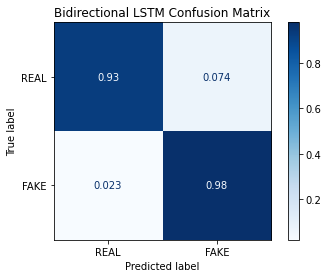

In [36]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Need to use other confusion matrix as deep learning models not supported with plot_confusion_matrix
cm = confusion_matrix(y_test, model_predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)


disp = disp.plot(cmap=plt.cm.Blues)
disp.ax_.set_title("Bidirectional LSTM Confusion Matrix")
plt.show()